In [16]:
#setup
options(repr.plot.width=22, repr.plot.height=22)
suppressPackageStartupMessages({
    library(admixtools)                                                  
    library(ape)                                                         
    library(tidyverse)  
    library(gplots)
    source("scripts//analysis.R")
})
setwd('~benjamin_peter/fstats_tutorial')

## 1. Estimating trees

Many methods to visualize population structure between many populations can be written as functions of a _distance matrix_, like a matrix of $F_2$ or $F_{ST}$-values. These methods include principal component analysis, trees and admixture graphs, the latter two we will focus on today. In distance matrices, large values mean that samples are less similar to each other, in contrast to similarity matrices where large values imply samples are _more_ alike.

In [17]:
#here we read all possible f2 values
f2s = read_f2('fdata/worldfoci2')

#we arrange them into a matrix
f2_mat = f2_matrix(f2s)

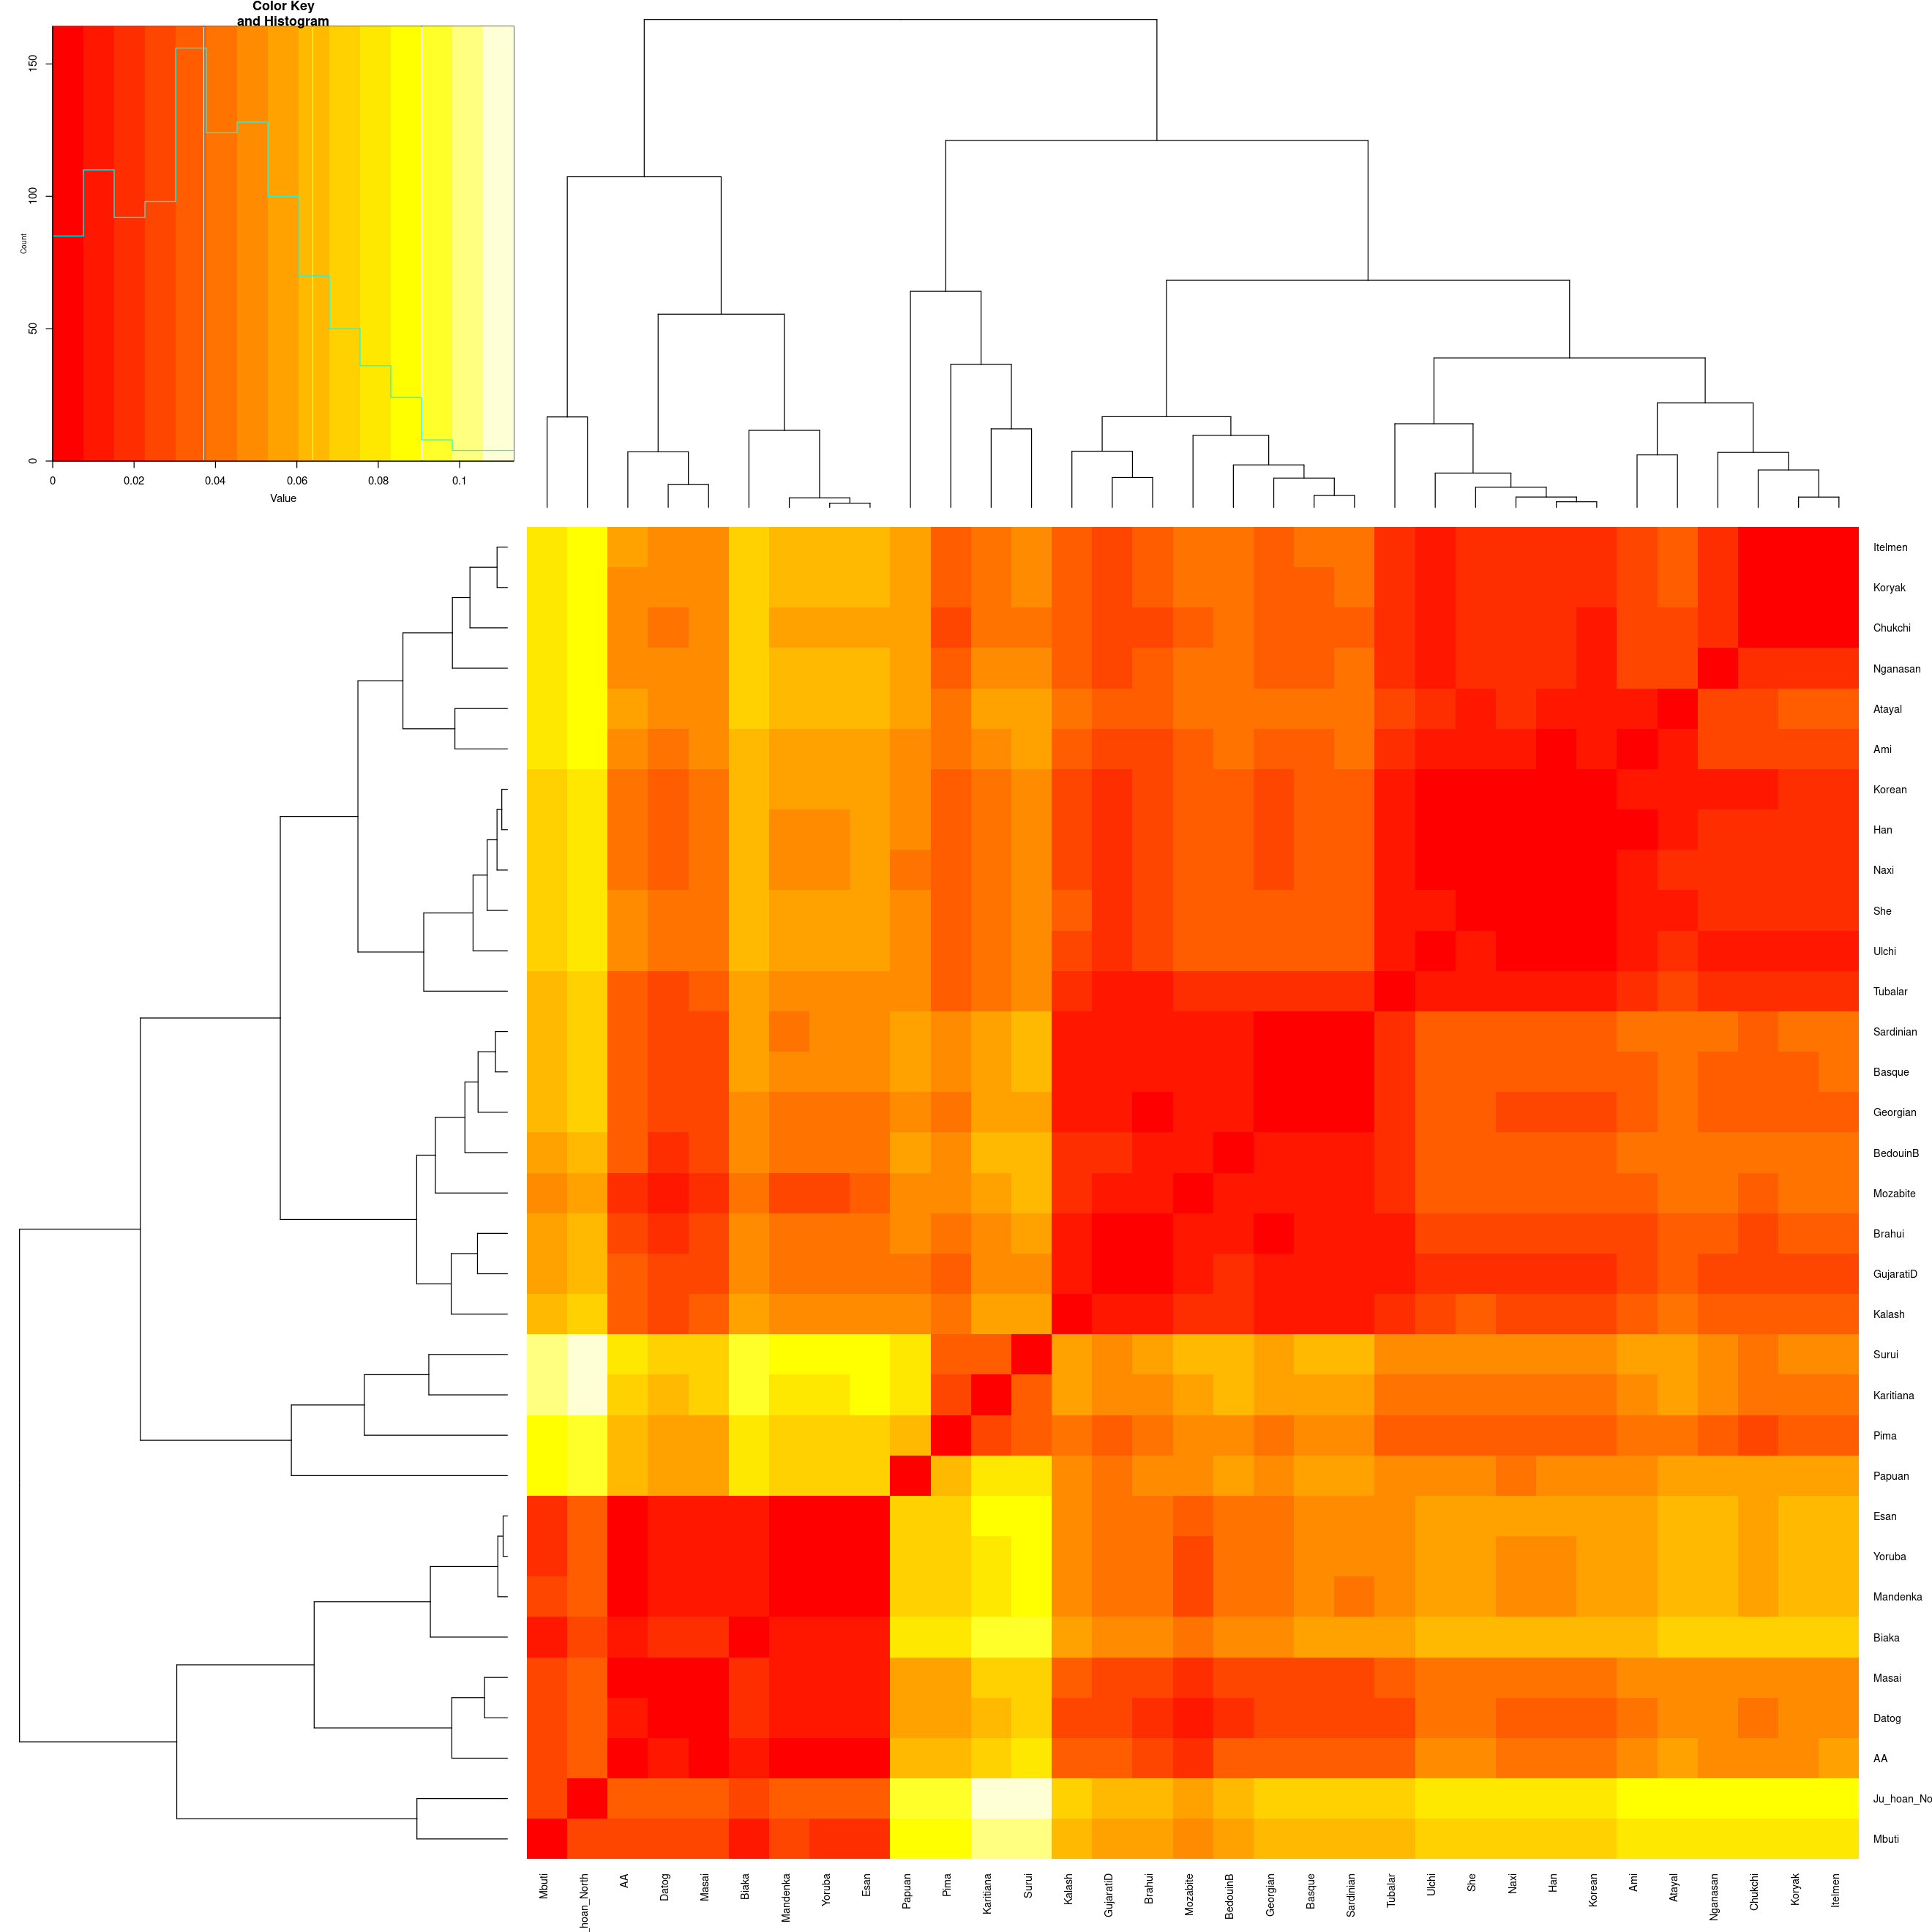

In [18]:
heatmap.2(f2_mat, symm=T, scale="none", trace='n')

**Task 1:** Use the distance matrix in the `f2_mat`-matrix to generate a tree using the neighbor joining algorithm.
Use the following functions from the `ape` package:
 
 - `nj()` to calculate the tree
 - `root()` to set an appropriate root
 - `plot.phylo()` to visualize your data

In case you are not sure how these functions work, the help (typing e.g. `?nj` may help)

**Questions:**
   - Can you tell which populations might be admixed?
   - how does that relate to $f_3$-statistics?

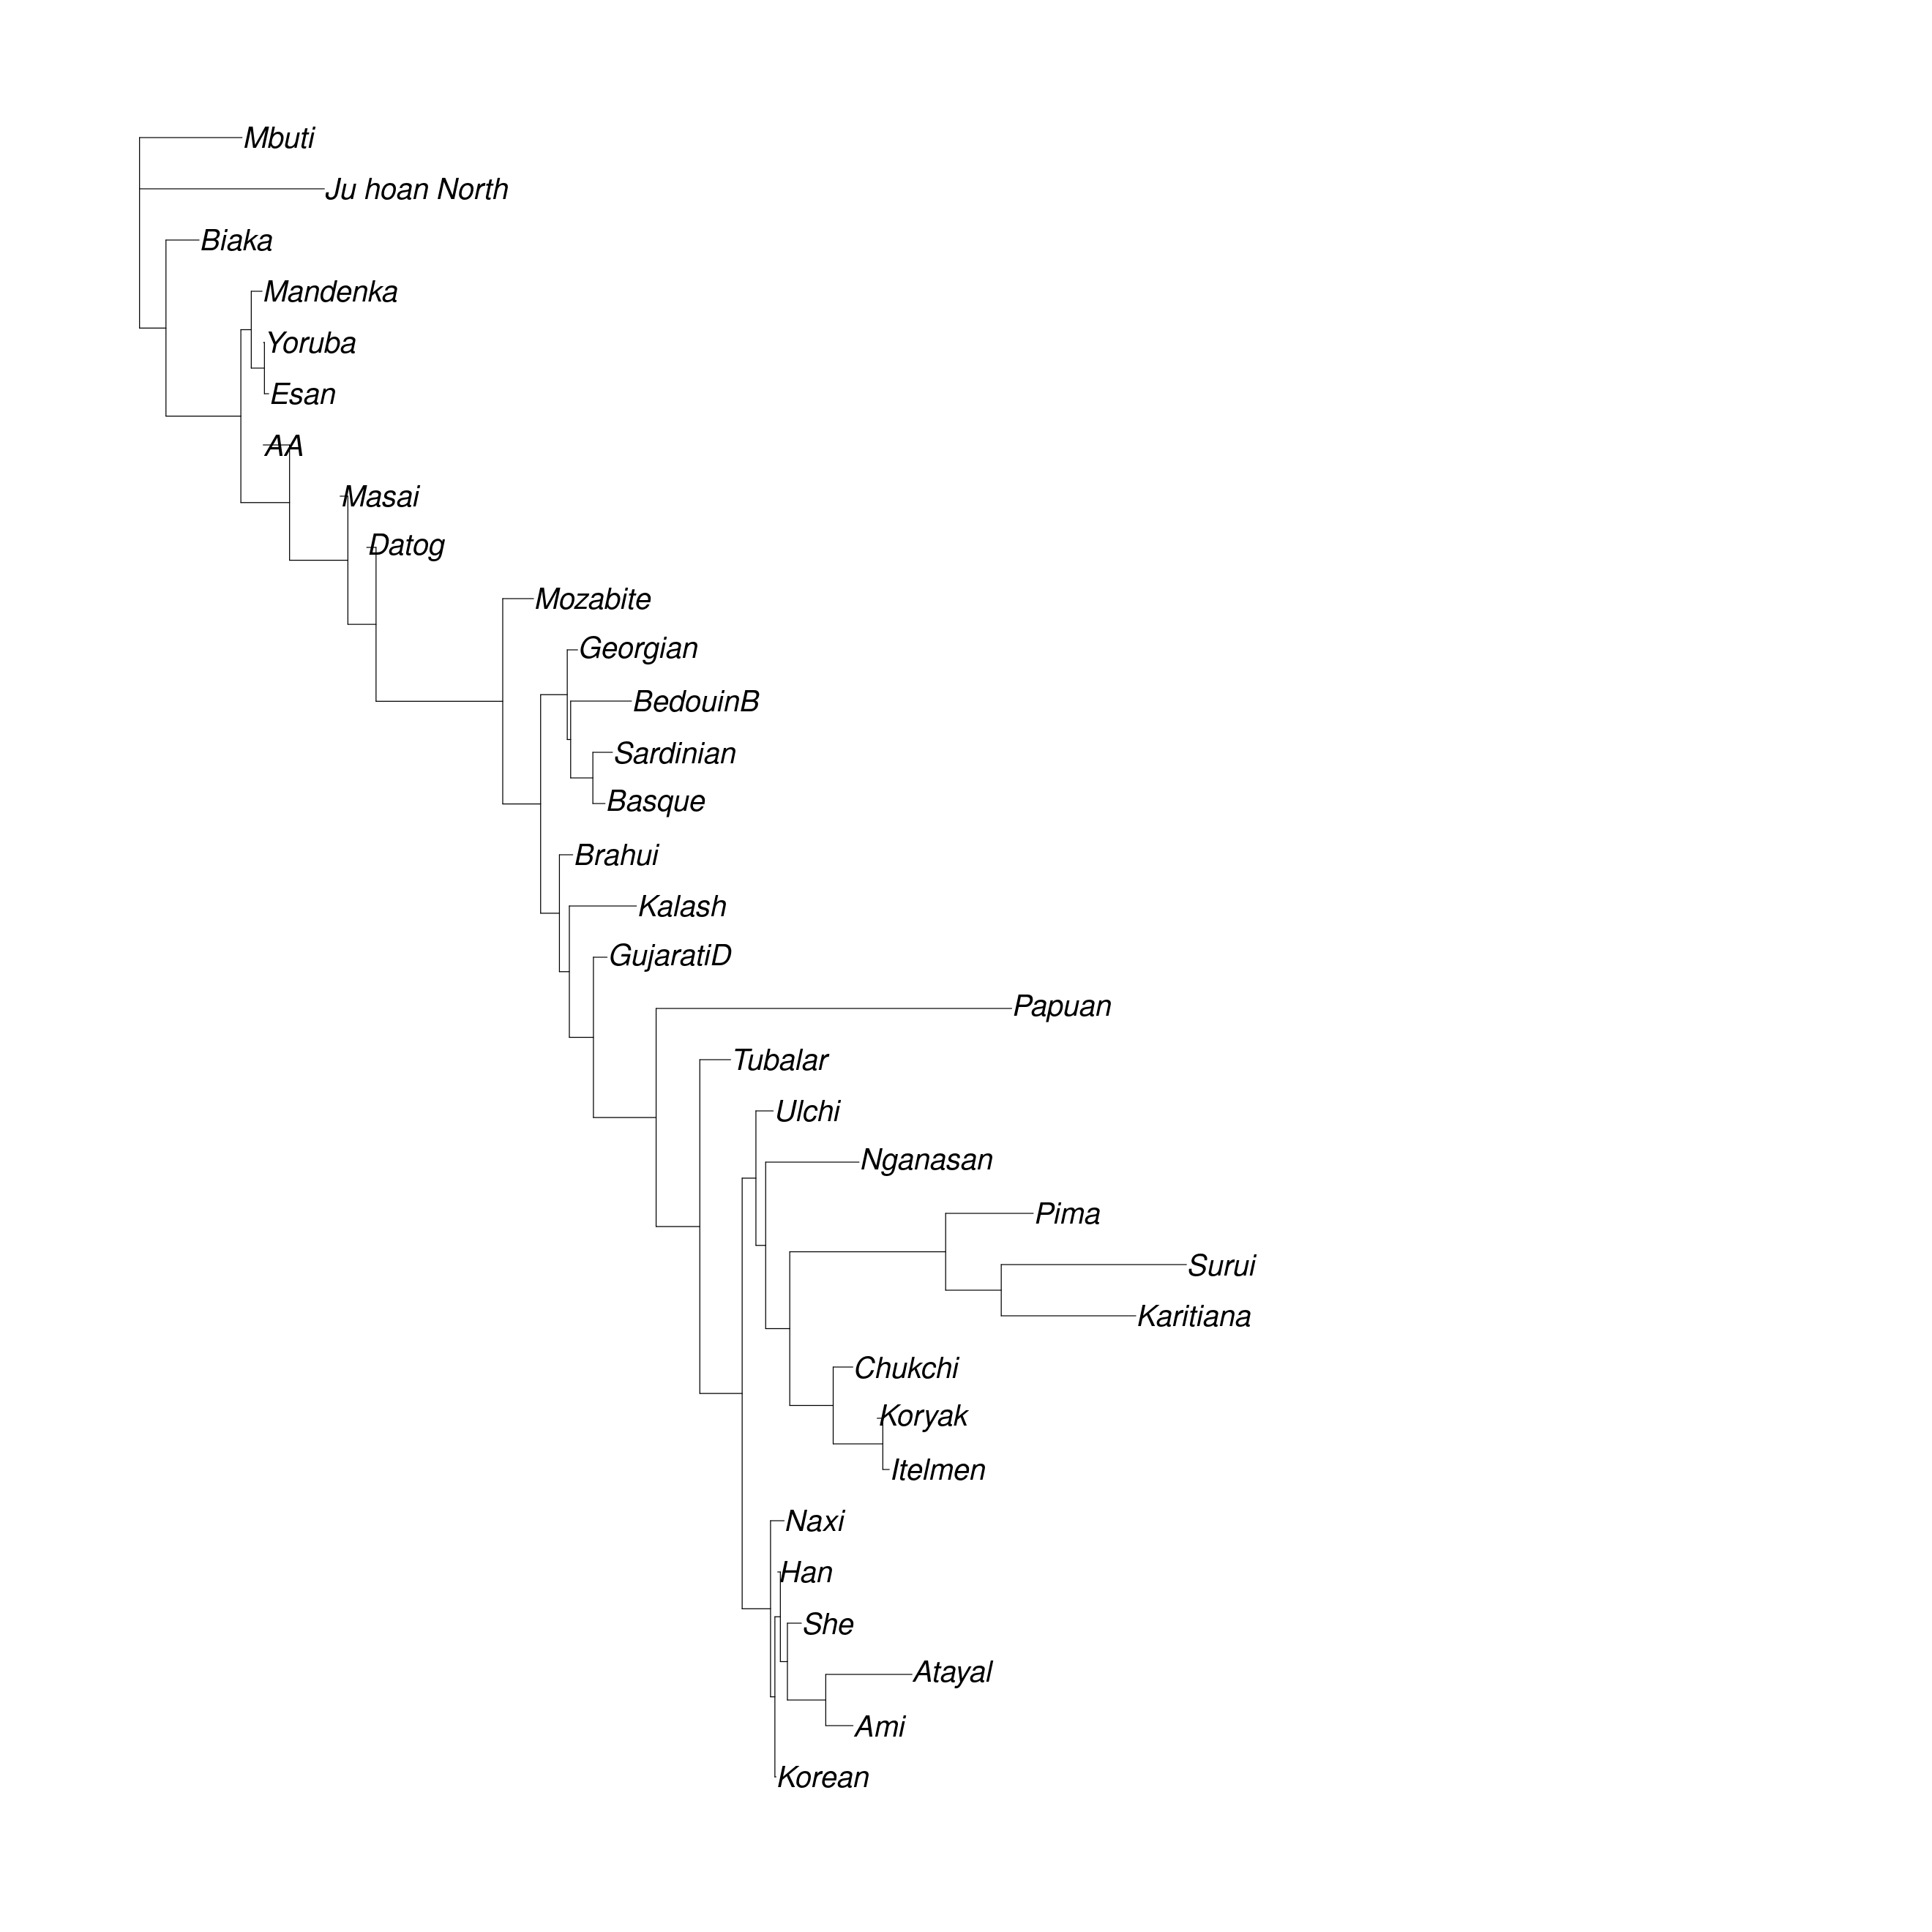

In [19]:
tree = f2_mat %>% nj %>% root("Mbuti")
plot(tree, cex=2)

## 2. Fitting admixture graphs using qpgraph
Our next task will be to use `qpgraph` to fit a graph. In contrast to `nj`, `qpgraph` does not estimate a graph, so one has to be specified. It will then fit all admixture proportions and branch lengths. One can think of this as obtaining "plausible" graphs that fit the data, without any statements whether they are the best or unique graph for that purpose. Thus, we have to specify a graph. The easiest way is to give it a list using 2 columns, where each row is anedge in the graph.

In [10]:
starting_graph = rbind(                   
              c("ROOT", "Mbuti"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),           
              c("AFR1", "AA"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "Sardinian"),         
              c("EUR","AA"),       
              c("EAS", "Han")             
              )                             

For this purpose, we have to define a bunch of internal nodes (a useful convention is to use ALL-CAPS for internal nodes). I.e. in our starting graph, we start at the root, where we us the _Mbuti_ as an outgroup. Within Africa, we have two populations; the African component of the African-American population (_AA_), and the out-of-Africa population (OOA). Outside Africa, we split into Europe (EUR) and East Asians (EAS), represented by the _Sardinian_ and _Han_, respectively. Our hypothesis is that the African-Americans have some European ancestry, therefore we add a second edge from `EUR` to `AA` to reflect that.

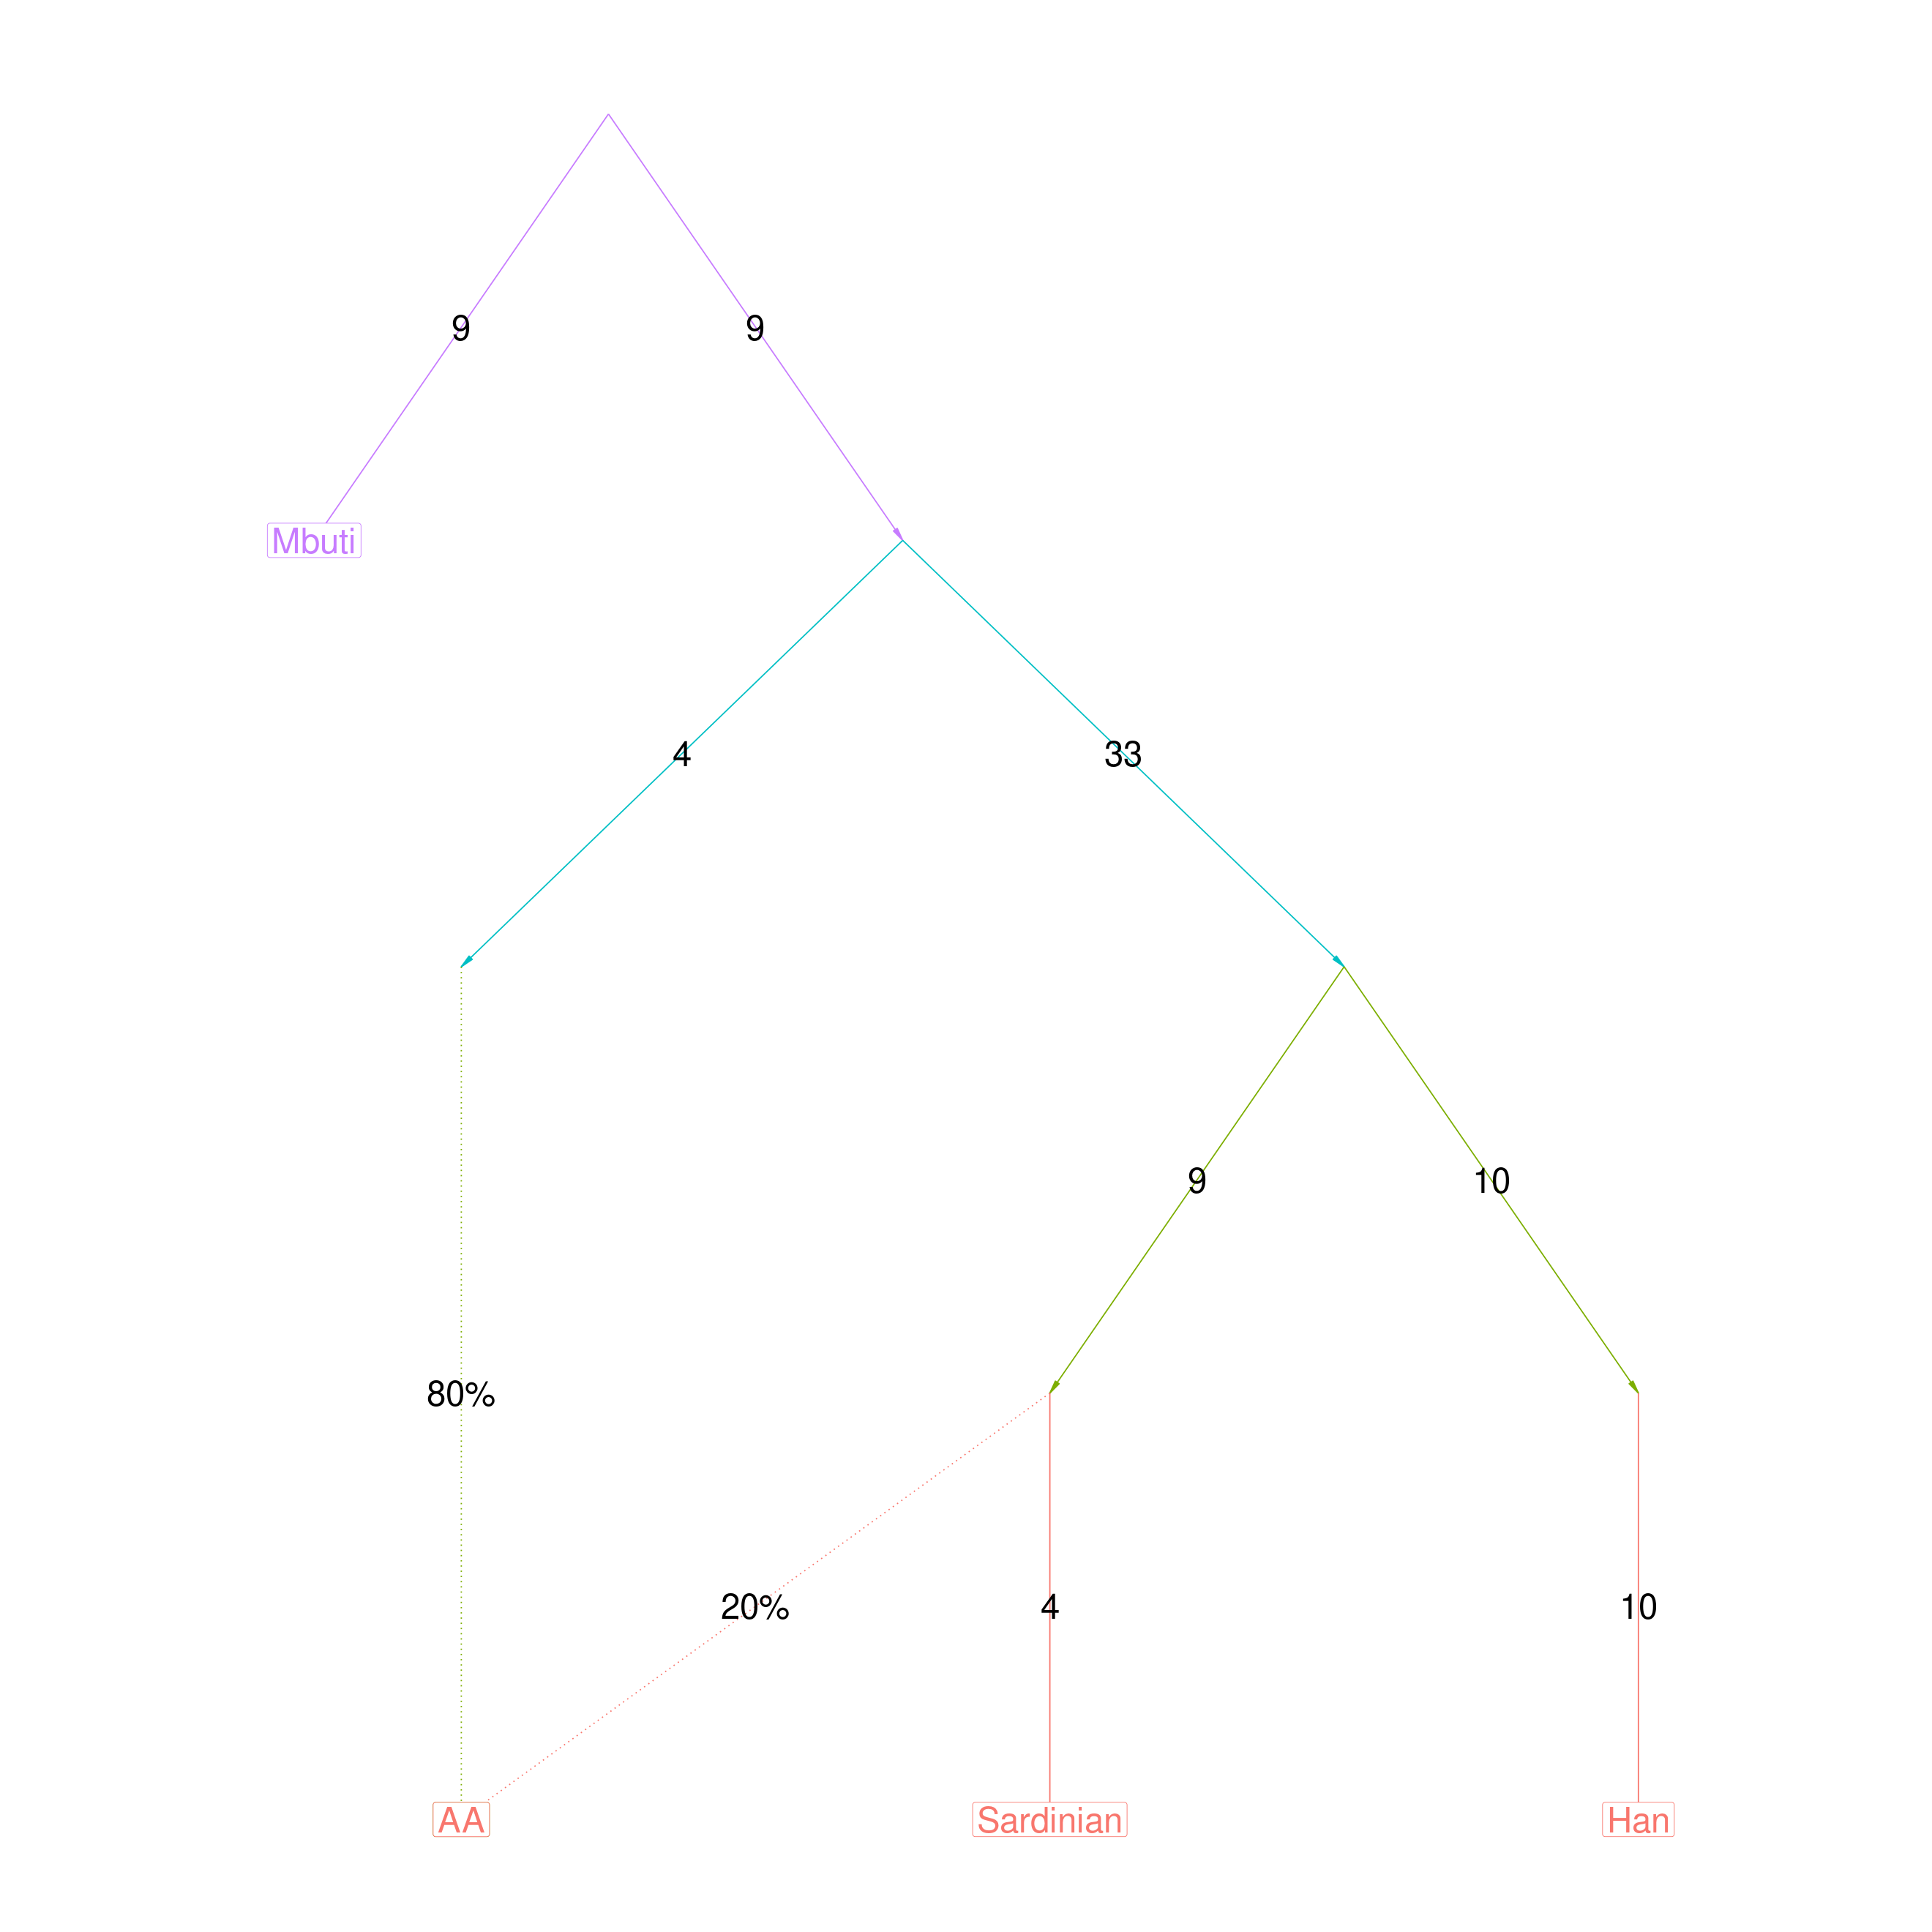

In [20]:
#fitting the graph is done using the qpgraph function:
G = qpgraph(f2s,starting_graph, return_fstats = T); 
plot_graph(G$edges, textsize=10)

Next, we can look at the fitted $f_2$-statistics

In [21]:
G$f2

pop1,pop2,est,se,fit,diff,z,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,AA,0.02298698,0.0002453600,0.02298578,1.193702e-06,0.004865104,0.9961182
Mbuti,Sardinian,0.06382167,0.0004345402,0.06381450,7.172723e-06,0.016506467,0.9868303
Mbuti,Han,0.07039192,0.0004803555,0.07038467,7.253161e-06,0.015099569,0.9879527
AA,Sardinian,0.03346784,0.0003150060,0.03346382,4.022769e-06,0.012770452,0.9898109
AA,Han,0.04344543,0.0003414332,0.04344026,5.170392e-06,0.015143205,0.9879179
Sardinian,Han,0.03200879,0.0003060188,0.03200954,-7.502725e-07,-0.002451720,0.9980438


the columns
- `est` is the estimated f3/f4-statistic
- `se` is the estimated standard error
- `fit` is the f3/f4-statistic calculated under the model
- `diff` and `z` give the difference `fit-est` and associated Z-score, respectively.

If there are no Z-scores above 3 (or below -3), the model is often considered a fit to the data (again, with no claim about whether it is the best model). In this simple example, we only have 6 $f_2$-values and estimate 6 parameters (5 branch lengths and one admixture coefficient), so it is not surprising that we obtain a perfect fit.

**Task 2:** Assume we want to compare this model where the `AA`-population only has African Ancestry. For this purpose, remove the edge from `EUR` to `AA_Denver` from the graph. Does this model also fit?


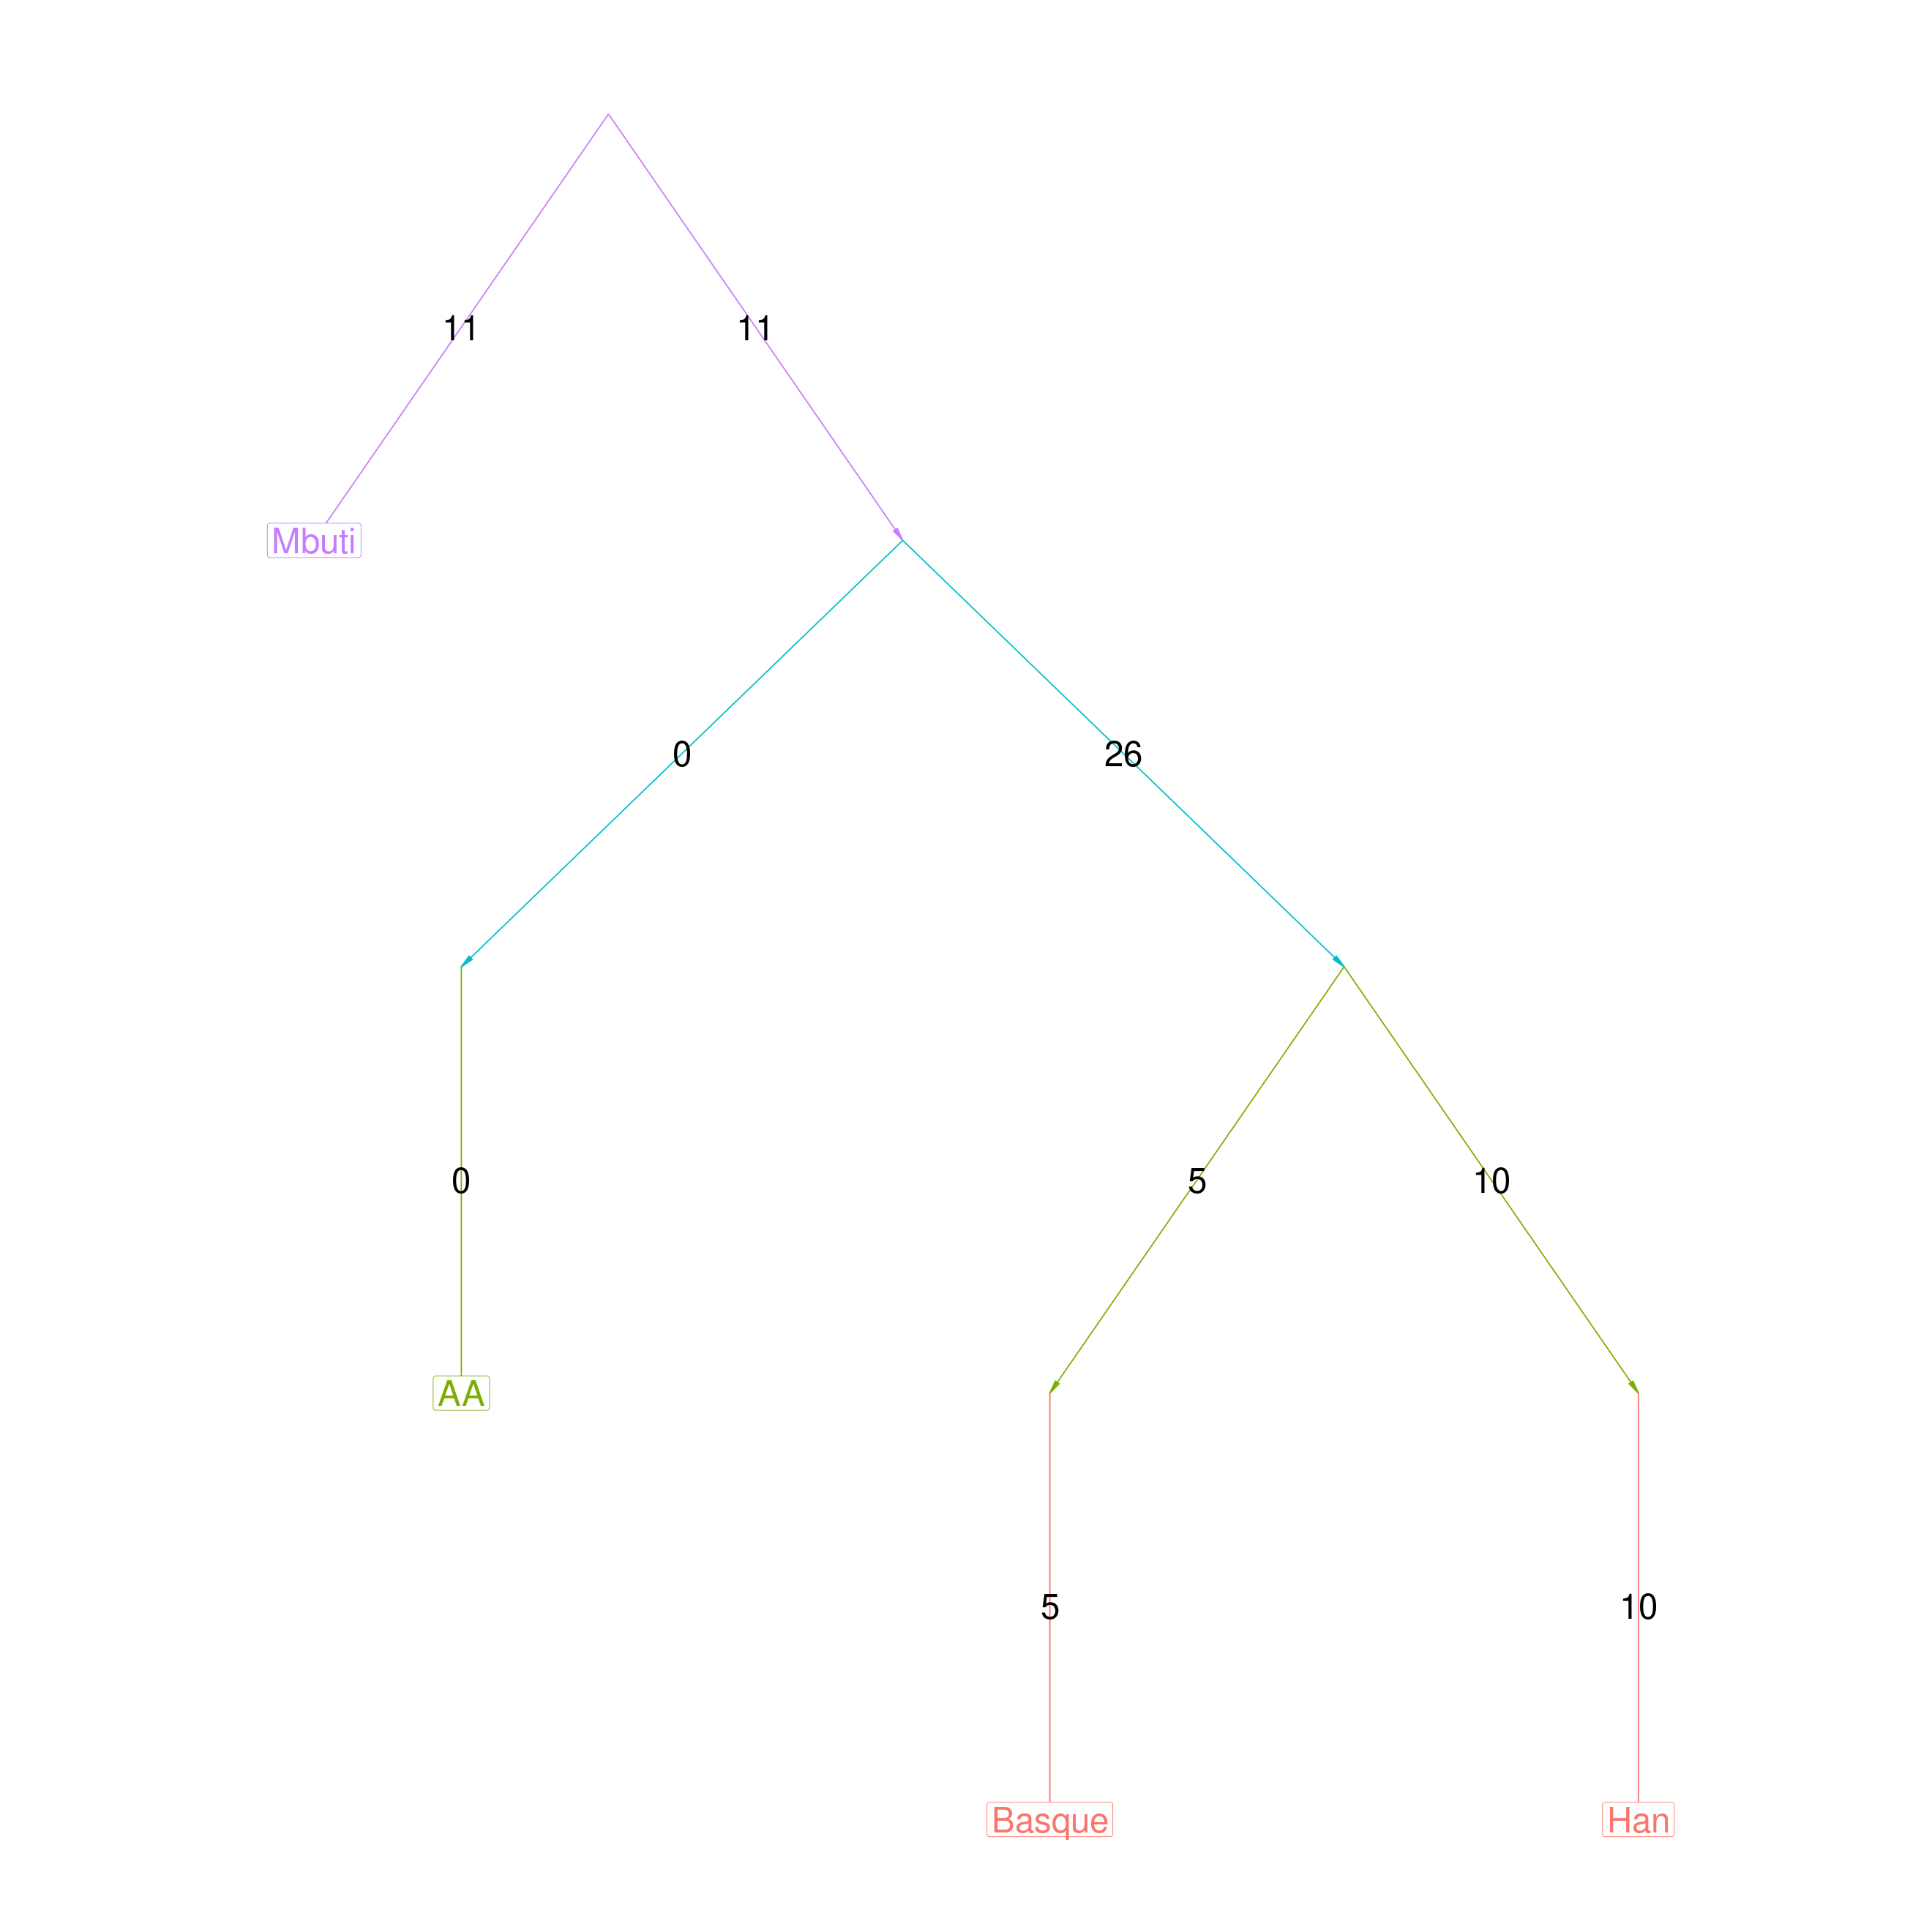

In [22]:
graph_task3 = rbind(                   
              c("ROOT", "Mbuti"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),           
              c("AFR1", "AA"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "Basque"),         
              #c("EUR","AA"),       
              c("EAS", "Han")             
              )                             
G3 = qpgraph(f2s,graph_task3,return_fstats=T); 
plot_graph(G3$edges, textsize=10)

In [14]:
G3$f2

pop1,pop2,est,se,fit,diff,z,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,AA,0.02298698,0.0002453600,0.02221882,0.0007681527,3.130716,1.743805e-03
Mbuti,Basque,0.06444548,0.0004344249,0.05878500,0.0056604834,13.029830,8.279141e-39
Mbuti,Han,0.07039192,0.0004803555,0.06772074,0.0026711791,5.560838,2.684821e-08
AA,Basque,0.03370974,0.0003165638,0.03656617,-0.0028564290,-9.023234,1.826168e-19
AA,Han,0.04344543,0.0003414332,0.04550192,-0.0020564870,-6.023103,1.711047e-09
Basque,Han,0.03107880,0.0002964535,0.03076564,0.0003131580,1.056348,2.908093e-01


**Task 3:** We picked `Basque` as a "proxy" for Europeans, and `Mbuti` as a proxy for Africans. What happens if we substitute them for other populations from the same region (e.g. `Basque -> Sardinian`, `Mbuti -> Yoruba`). What would happen if we all add `Yoruba`, `Mbuti`, `Sardinian` and `Basque` to the model? 

pop1,pop2,est,se,fit,diff,z,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,Sardinian,0.06382167,0.0004345402,0.0638145,7.172719e-06,0.01650646,0.9868304


pop1,pop2,est,se,fit,diff,z,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Yoruba,AA,0.003055913,7.271039e-05,0.002228704,0.0008272095,11.37677,5.458266e-30


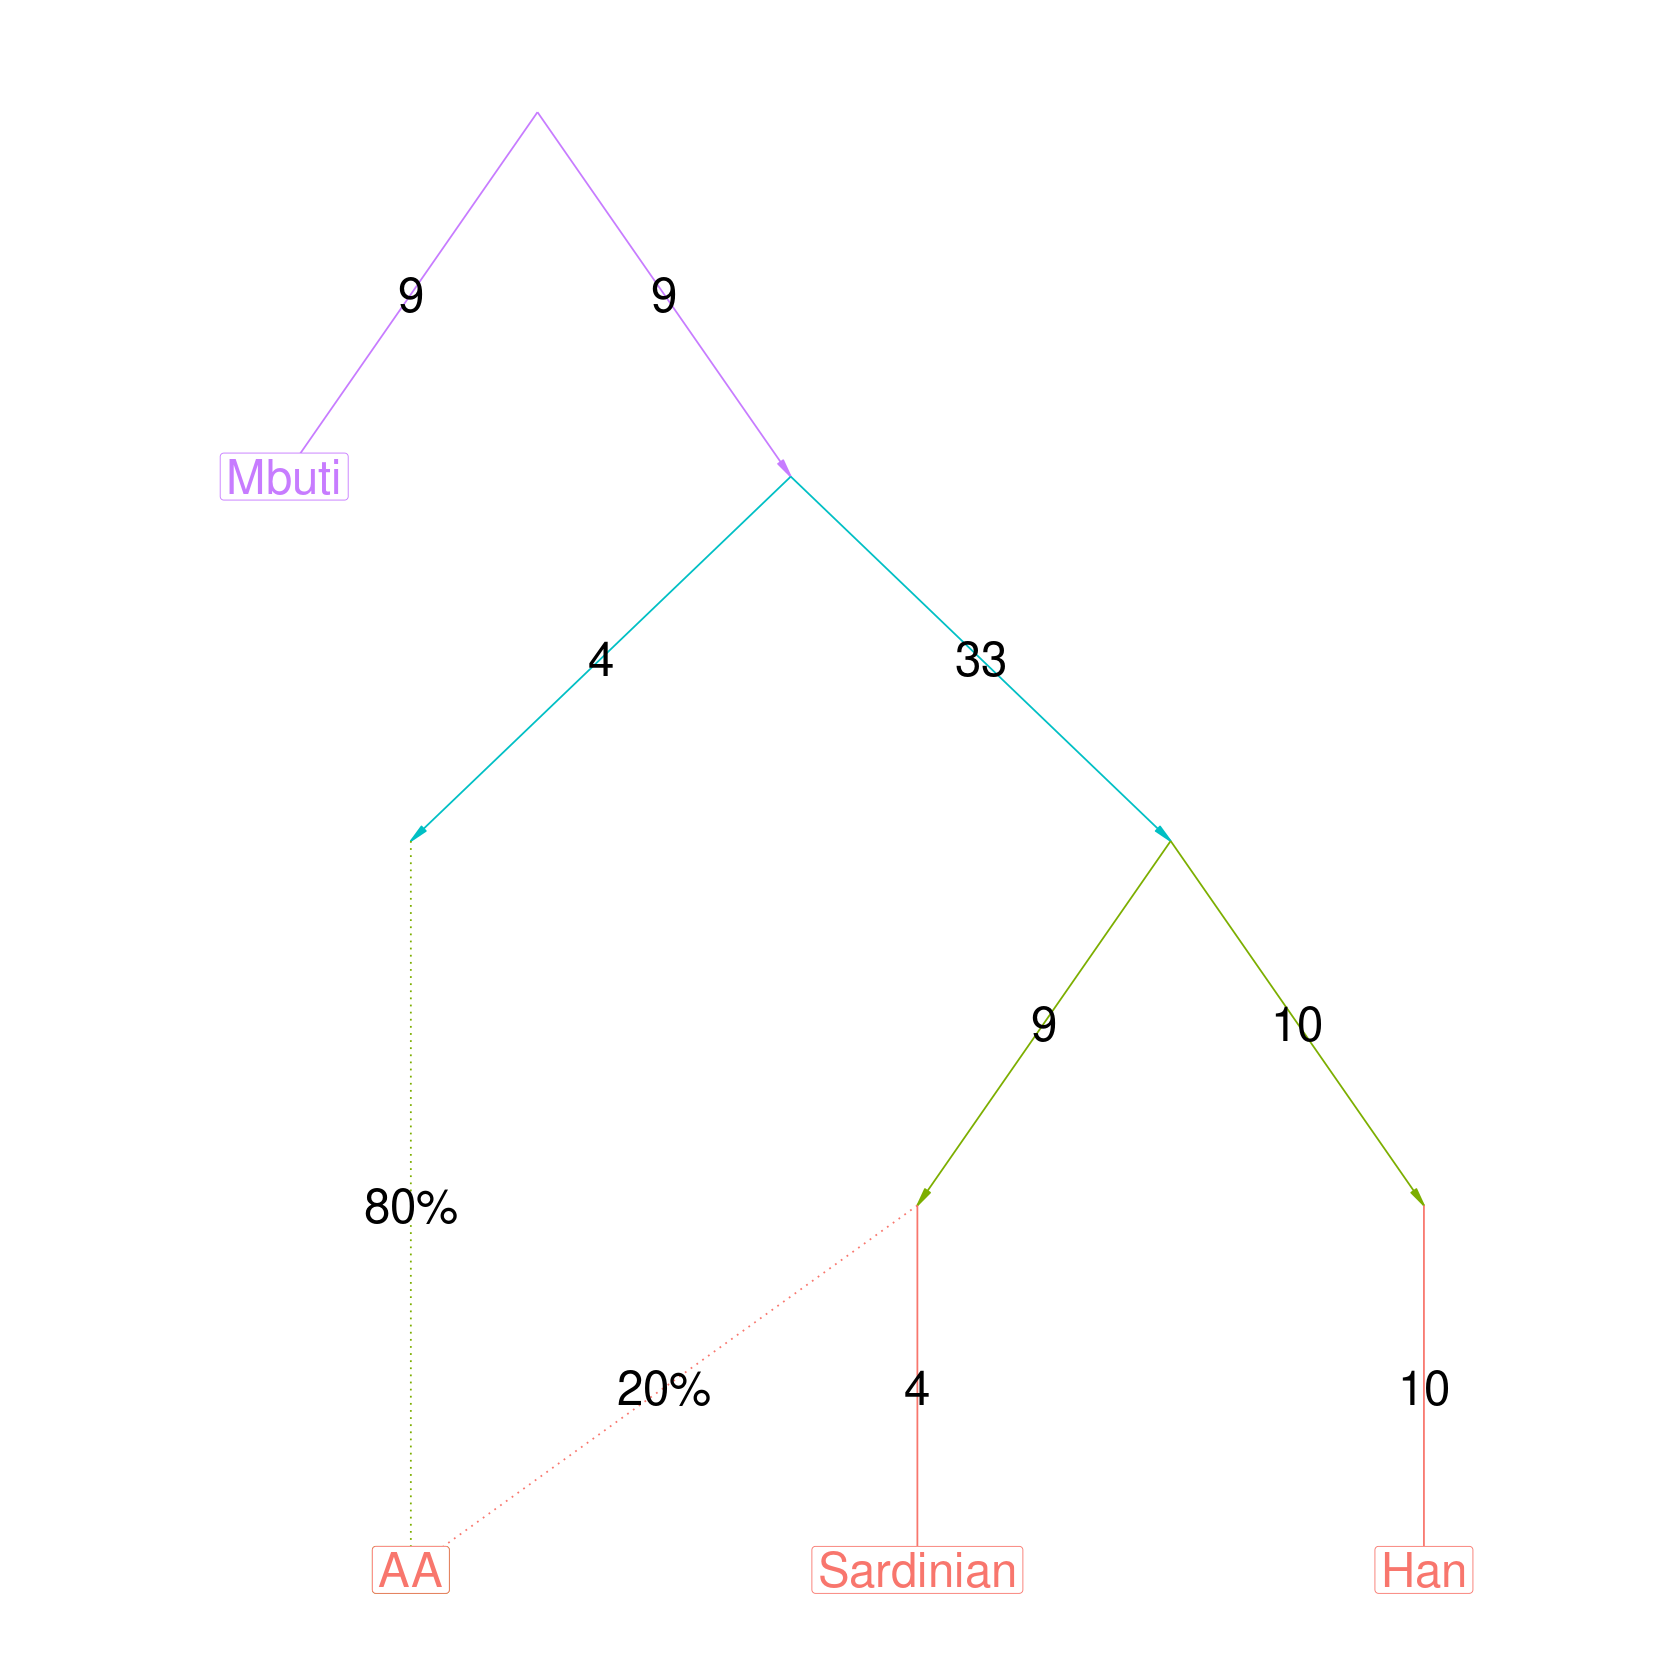

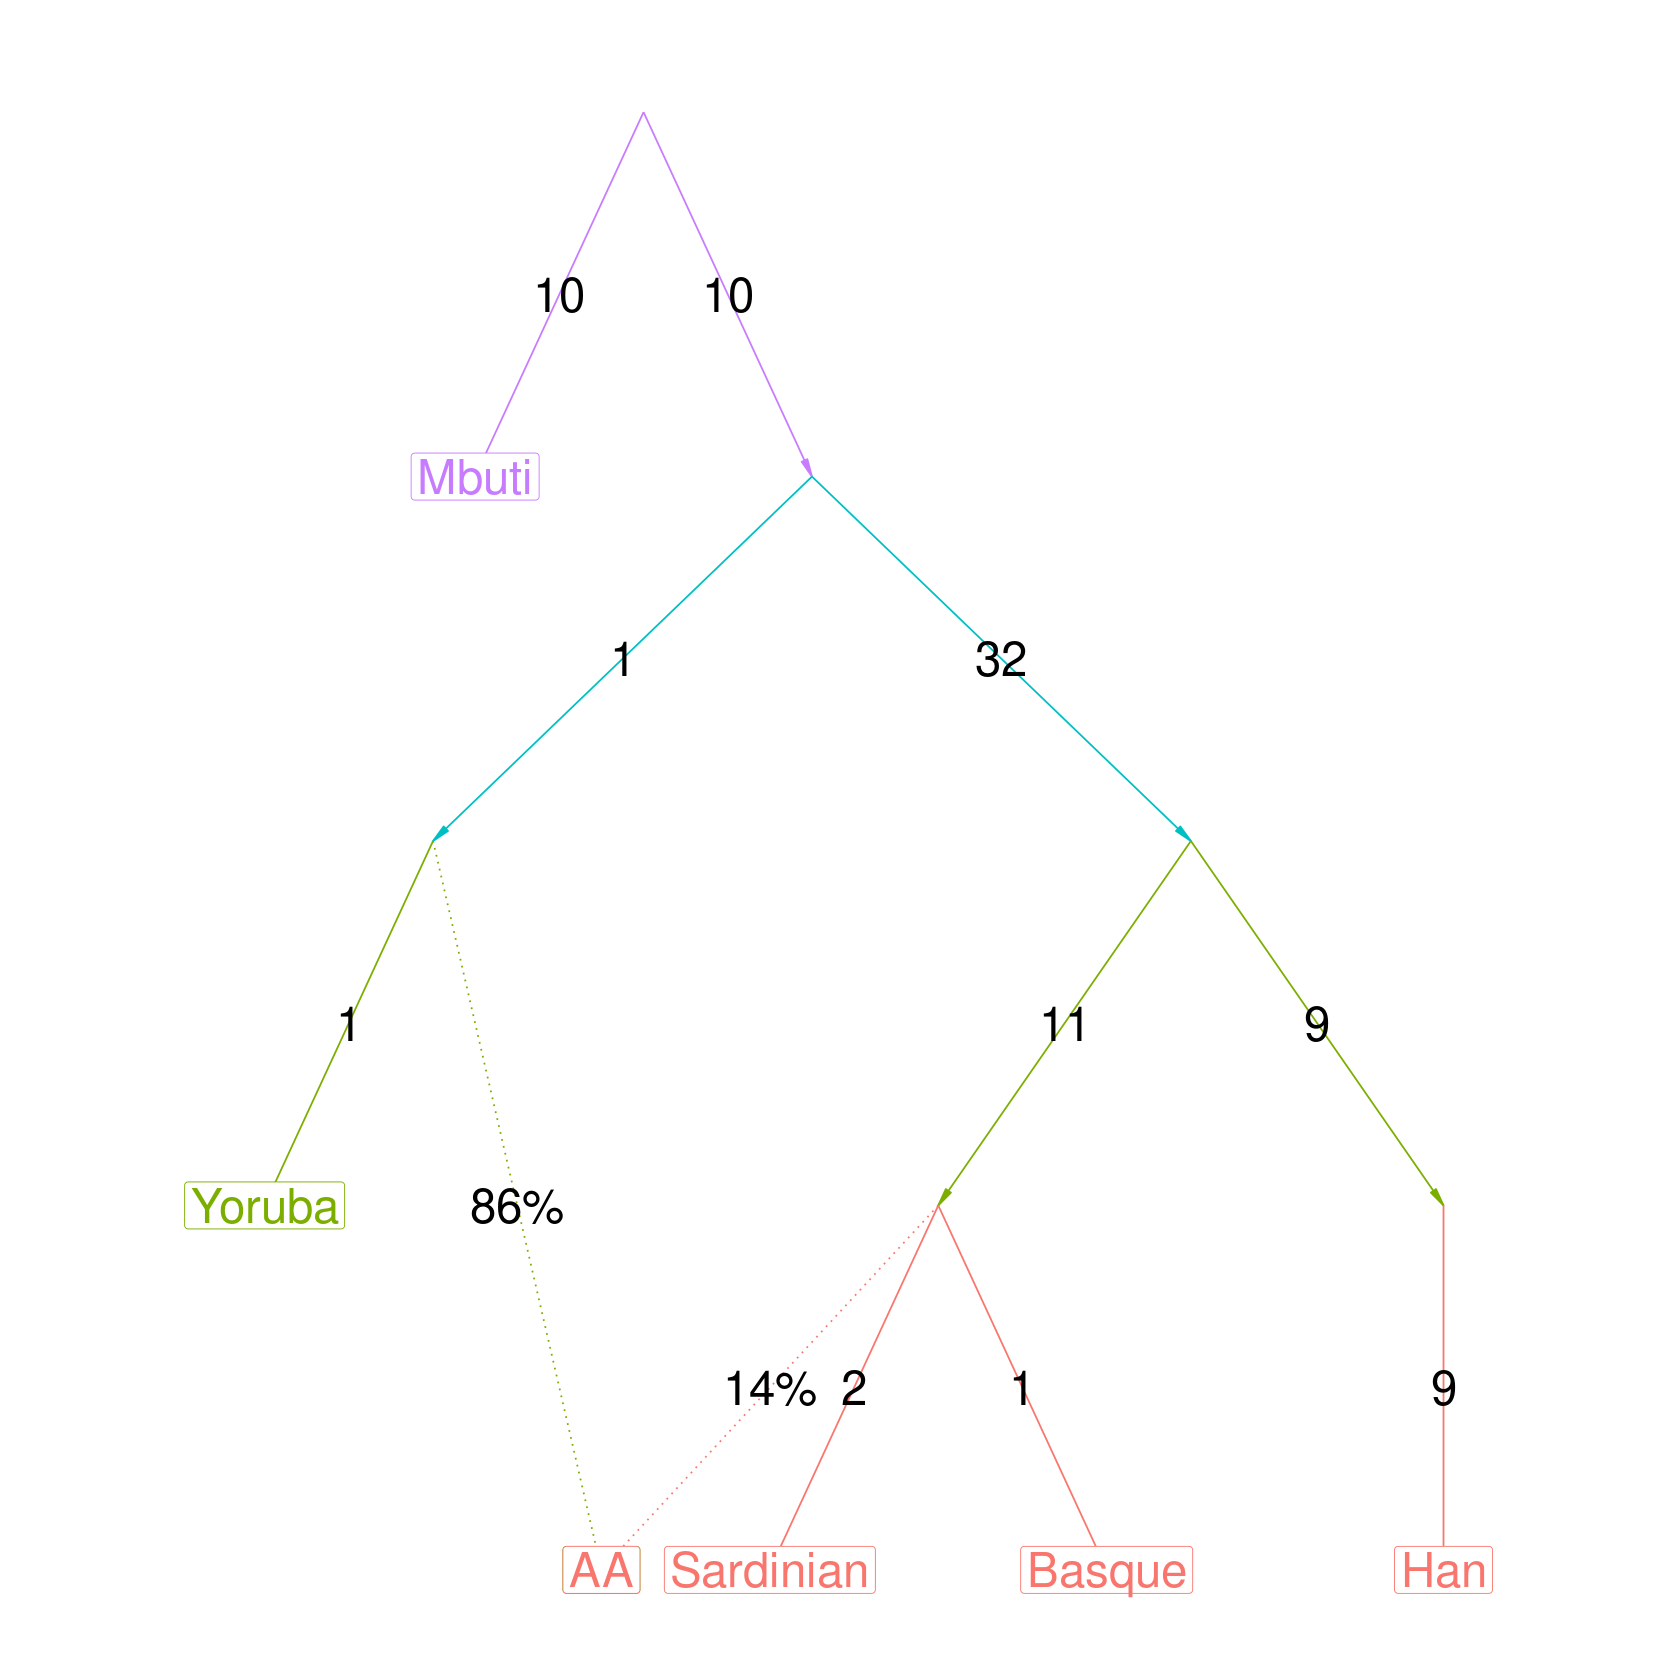

In [23]:
options(repr.plot.width=14, repr.plot.height=14)

graph_task41 = rbind(                   
              c("ROOT", "Mbuti"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),           
              c("AFR1", "AA"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "Sardinian"),         
              c("EUR","AA"),       
              c("EAS", "Han")             
              )                             

graph_task42 = rbind(                   
              c("ROOT", "Mbuti"),       
              c("ROOT", "AFR"),              
              c("AFR", "AFR1"),  
              c("AFR1", "Yoruba"),
              c("AFR1", "AA"),     
              c("AFR", "OOA"),            
              c("OOA", "EUR"),            
              c("OOA", "EAS"),            
              c("EUR", "Sardinian"),   
              c("EUR", "Basque"),         
              c("EUR","AA"),       
              c("EAS", "Han")             
              )                  


G41 = qpgraph(f2s,graph_task41,return_fstats=T); 
G42 = qpgraph(f2s,graph_task42,return_fstats=T); 
G41$f2[which.max(G41$f2$z),]
G42$f2[which.max(G42$f2$z),]
plot_graph(G41$edges, textsize=10)
plot_graph(G42$edges, textsize=10)

## 4. Estimating Admixture Graphs using Treemix
`qpgraph` has the drawback that the user needs to specify the graph. This has the advantage that we retain fine-scale control over the fitting, but in many cases we would like to have a way to estimate the tree from data. 

This is the problem addressed by `treemix` [(Pickrell & Pritchard 2012)](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002967). Unfortunately, the program has not been maintained for the last five+ years, so it is a little bit tedious to use. For this exercise, I converted the input files for the `world`-data set to treemix format (in `treemix/worldfoci2.treemix.in.gz`), and ran treemix with 0 to 5 admixture edges ((`-m 0` to `-m 5`), the resultreemix/worldfoci2.treemix.m0

In [24]:
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 0 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m0")
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 1 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m1")
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 2 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m2")
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 3 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m3")
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 4 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m4")

In [32]:
system("treemix -i treemix/worldfoci2.treemix.in.gz -m 5 -k 1000 -root Mbuti -o treemix/worldfoci2.treemix.m5")

Warning message in plot_treemix("treemix/worldfoci2.treemix.m4"):
“NAs introduced by coercion”
Warning message in plot_treemix("treemix/worldfoci2.treemix.m4"):
“NAs introduced by coercion”
Warning message in plot_treemix("treemix/worldfoci2.treemix.m4"):
“NAs introduced by coercion”
Warning message in plot_treemix("treemix/worldfoci2.treemix.m4"):
“NAs introduced by coercion”


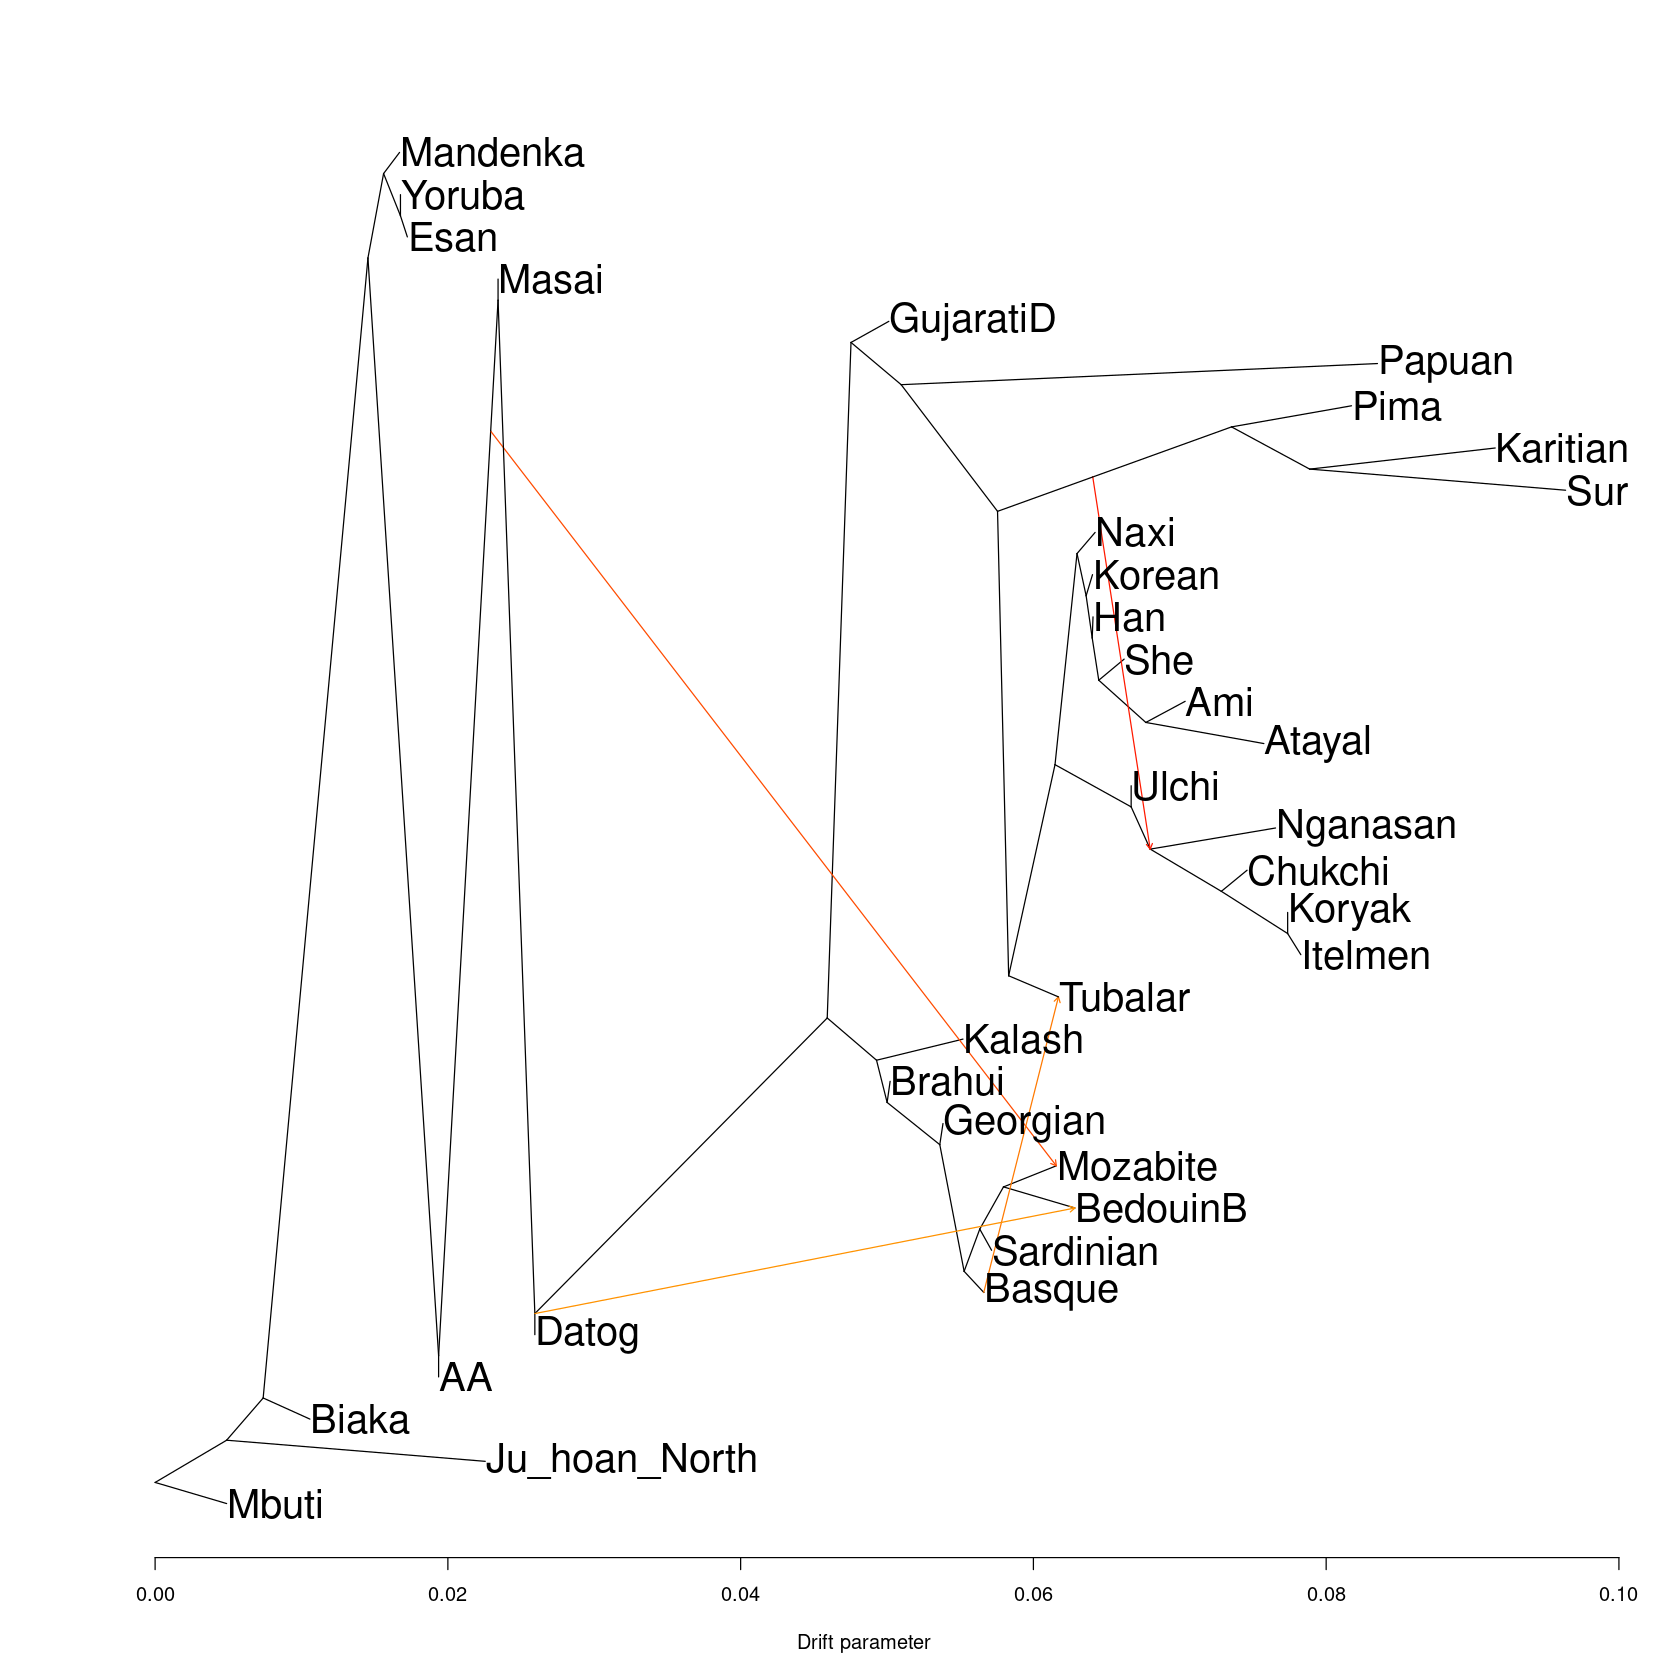

In [31]:
source("scripts//treemix_plotting2.R")
tm = plot_treemix('treemix/worldfoci2.treemix.m4')


Warning message in xy.coords(x, y, xlabel, ylabel, log):
“NAs introduced by coercion”


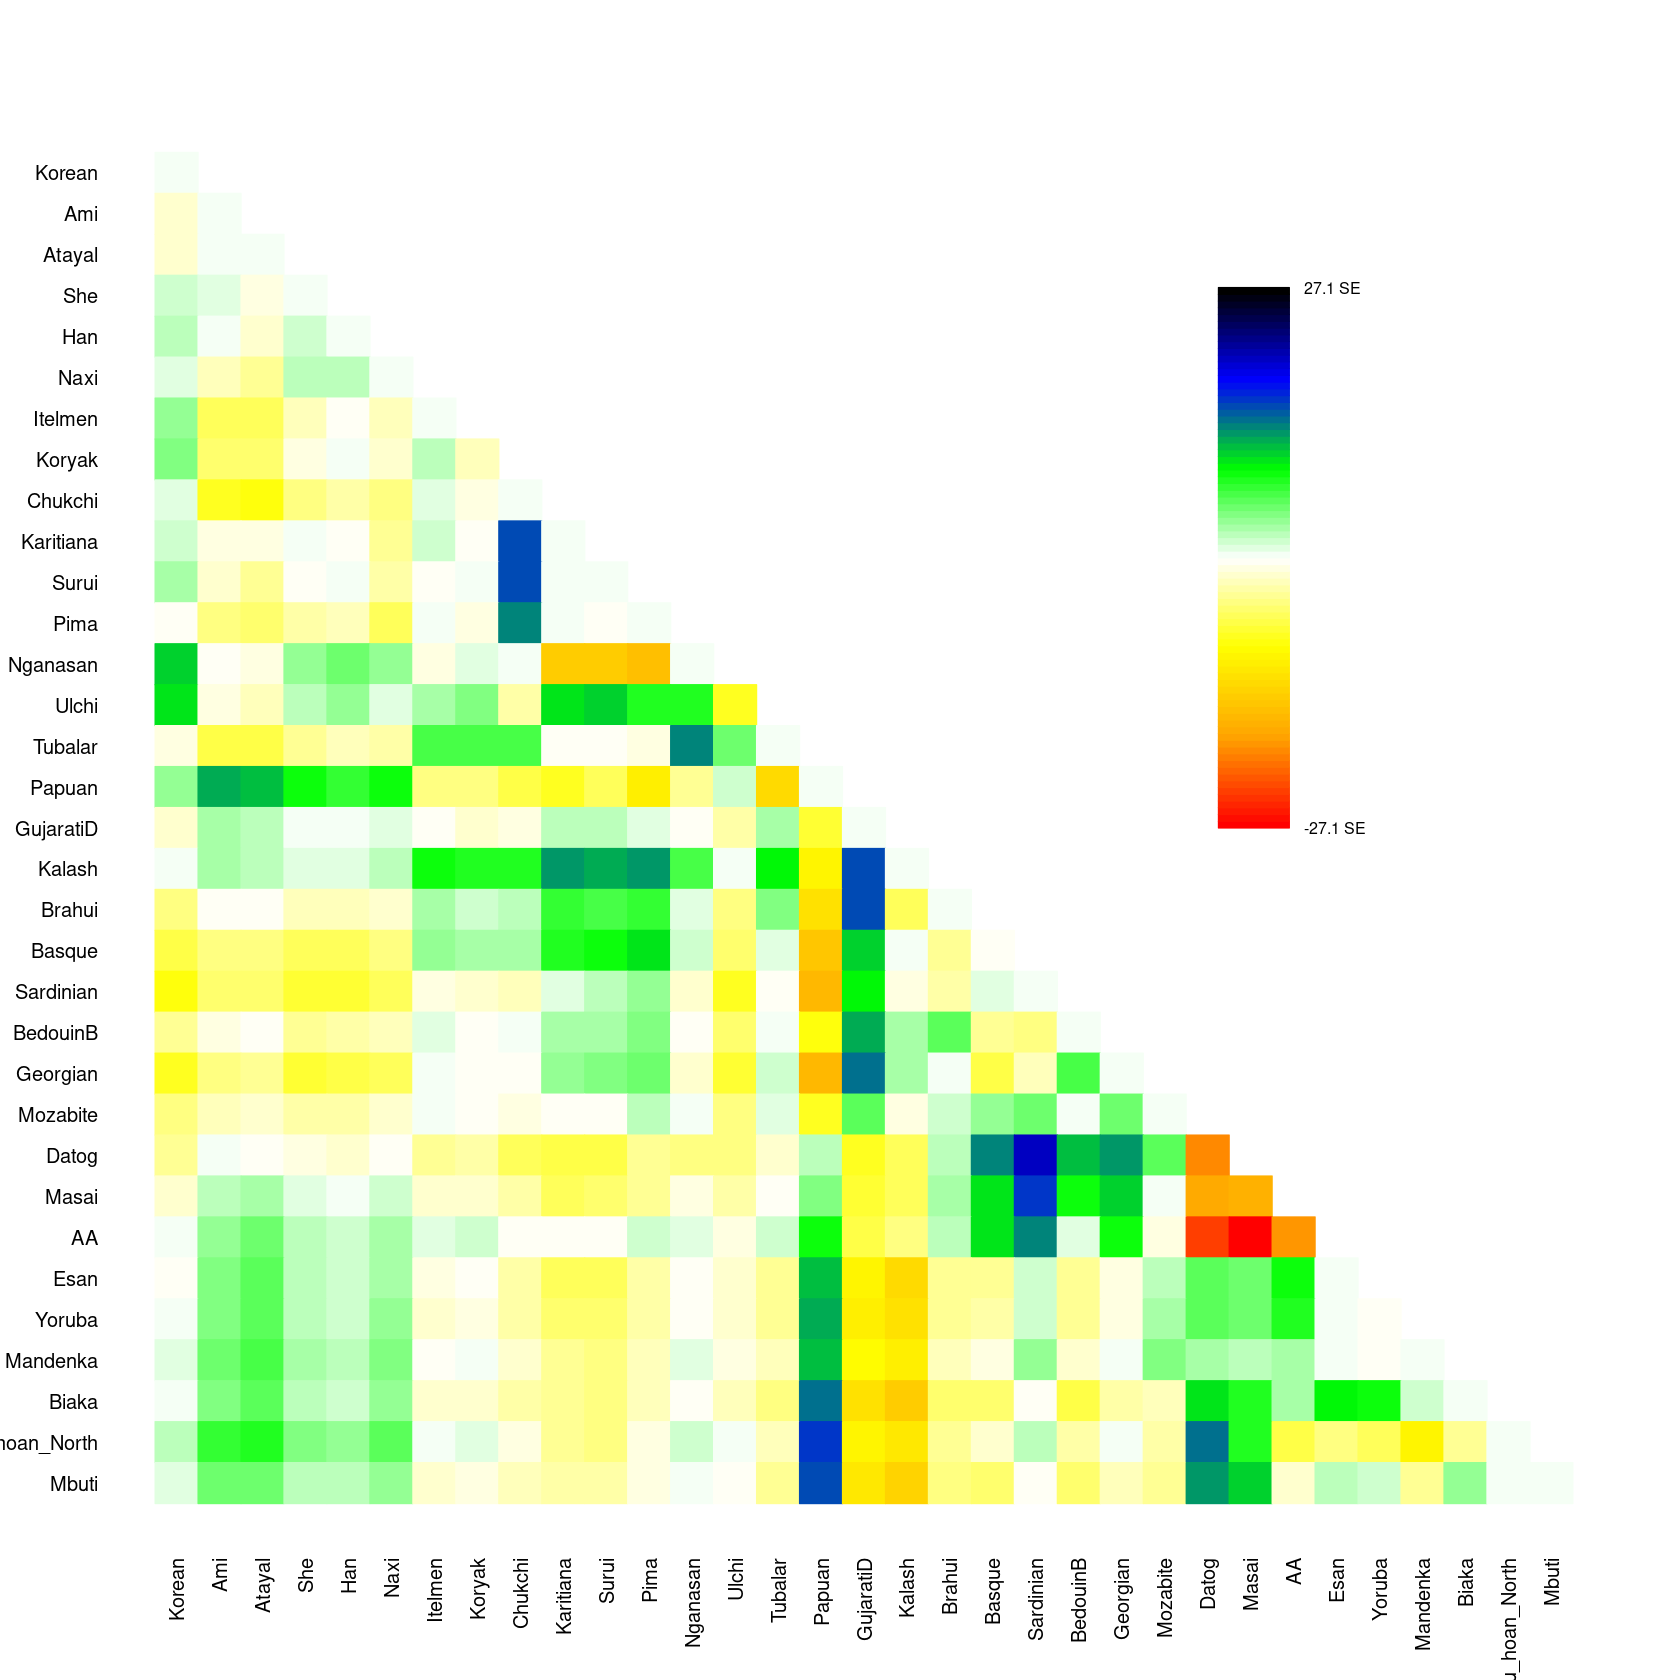

In [28]:
res = plot_resid('treemix/worldfoci2.treemix.m4', pop_order=get_tip_order(tree))